In [1]:
import numpy as np
import xarray as xr
# import itertools
import matplotlib.pyplot as plt
# from cartopy import geodesic
# import cartopy.crs as ccrs
# import shapely
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import draft_functions as funk
import cmocean.cm as cmo

from scipy import stats


In [34]:
initial_depth = -5100  # int(sys.argv[1])  # 5 # 60 # 5179
lon_sample = 6.287  # 6.25
lat_sample = -32.171  # -32.171§
origin = (lon_sample, lat_sample)

start_time = datetime.strptime('2019-01-20 12:00:00', '%Y-%m-%d %H:%M:%S')
sim_time = 4484
# create the date range in reverse from sampling time to the past
datelist = pd.date_range(end=start_time, periods=sim_time)[::-1]
end_time = datelist[0]

depth_bins = np.linspace(-5500, 0, 56)  # creates a 100m bins

simulations = ['0', '10000']#['_nodiff', '', '_invKzdet']
sim_names = ['inf', '10000']#['NoDiff', 'Diff', 'InvDiff']

In [35]:
# %% Extracting the data from simulation outputs
frag_into_NPs = {}


for k, ft in enumerate(tqdm(simulations)):
    # print('Computing fragmentation timescale: ', ft)
    local_path = f'/storage/shared/oceanparcels/output_data/data_Claudio/hc13_2/hc13_{ft}.zarr'
    sim = xr.open_zarr(local_path)
    nano = sim.where(sim.radius < 1e-6/2, drop=False)
    sim_dict = {}
    print(local_path)
    
    # Find indices of the particles that are not NaN
    aux = np.isnan(nano['radius'].values)
    traj = nano.trajectory.values
    index_MP = np.sum(aux, axis=1)
    index_NP = len(nano.obs) - 1 - np.sum(aux, axis=1)
    sim_dict['particle_index'] = index_NP
    
    # Get depth, latitude, and longitude of NPs
    z = -nano['z'].values
    sim_dict['depths'] = z[(traj, index_NP)]

    latNP = nano['lat'].values
    lonNP = nano['lon'].values

    sim_dict['lat'] = latNP[(traj, index_NP)]
    sim_dict['lon'] = lonNP[(traj, index_NP)]
    sim_dict['time'] = nano['time'].values[(traj, index_NP)]
    sim_dict['radius'] = nano['radius'].values[(traj, index_NP)]
    sim_dict['frag_events'] = nano['frag_events'].values[(traj, index_NP)]

    # Compute displacement of NPs from a reference point (origin)
    xy_pos = (lonNP[(traj, index_NP)], latNP[(traj, index_NP)])
    sim_dict['displacement'] = funk.haversine(origin, xy_pos)

    # Compute histograms of particle counts for each depth bin over time
    zbins = len(depth_bins)-1
    hist_counts = np.zeros((zbins, sim_time))
    t_range = range(0, sim_time, 1)
    
    
    for i, fr in enumerate(tqdm(t_range)):
        x = np.histogram(-nano['z'][:, fr].dropna('trajectory'), bins=depth_bins,
                         density=False)
        hist_counts[:, i] = x[0]

    # Compute total number of particles in each time step
    total_particles = np.sum(hist_counts, axis=0)
    sim_dict['counts'] = total_particles

    p_zt = np.ma.masked_equal(hist_counts, 0) #/total_particles
    # creat a rolling average of h_masked

    sim_dict['vertical_distribution'] = p_zt

    frag_into_NPs[sim_names[k]] = sim_dict
    


  0%|          | 0/2 [00:00<?, ?it/s]

/storage/shared/oceanparcels/output_data/data_Claudio/hc13_2/hc13_0.zarr


 50%|█████     | 1/2 [05:18<05:18, 318.75s/it]

/storage/shared/oceanparcels/output_data/data_Claudio/hc13_2/hc13_10000.zarr


100%|██████████| 2/2 [10:36<00:00, 318.06s/it]


In [27]:
frag_into_NPs.keys()

dict_keys(['inf'])

/tmp/ipykernel_537608/4077894239.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[j].pcolormesh(x, y, frag_into_NPs[ft]['vertical_distribution'],


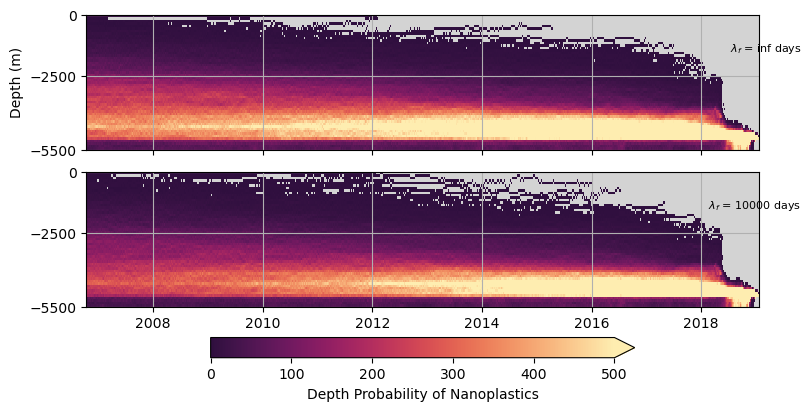

In [36]:
x, y = np.meshgrid(datelist, depth_bins)

fig, ax = plt.subplots(ncols=1, nrows=len(simulations), figsize=(8,4),
                       sharex=True, constrained_layout=True)

color_map = cmo.matter_r

for j, ft in enumerate(sim_names):
    
    ax[j].set_facecolor('lightgrey')
    im = ax[j].pcolormesh(x, y, frag_into_NPs[ft]['vertical_distribution'],
                          cmap=color_map,
                          vmin=0, vmax=500)
    
    ax[j].text(18200, -1500, f'$\lambda_f$ = {ft} days', fontsize=8,
               ha='right')
    ax[j].set_yticks([-5500, -2500, 0])
    ax[j].grid()

ax[0].set_ylabel('Depth (m)')

fig.colorbar(im, ax=ax[-1], orientation='horizontal',
             extend='max', label='Depth Probability of Nanoplastics')

# ax[0].set_title('Nanoparticles (50-1000 $nm$) in the water column')
plt.show()
fig.savefig('../article_figs/vertical_distributionsNPs.png', dpi=300,
            facecolor=(1, 0, 0, 0))


In [40]:
local_path = f'/storage/shared/oceanparcels/output_data/data_Claudio/hc13_2/hc13_0.zarr'
sim = xr.open_zarr(local_path)

In [42]:
sim['radius'][:,0]

<xarray.DataArray 'radius' (trajectory: 8192)>
dask.array<getitem, shape=(8192,), dtype=float64, chunksize=(8192,), chunktype=numpy.ndarray>
Coordinates:
    obs         int32 0
  * trajectory  (trajectory) int64 0 1 2 3 4 5 ... 8186 8187 8188 8189 8190 8191
Attributes:
    long_name:      
    standard_name:  radius
    units:          unknown

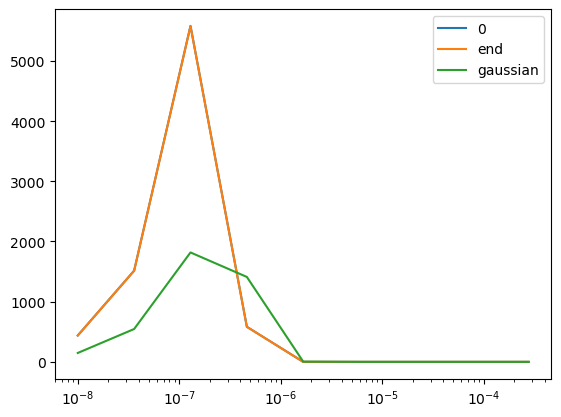

In [61]:
log_bins = np.logspace(-8, -3, 10)
#make a log scale histogram of the radiuses


counts, __ = np.histogram(sim['radius'][:,0], bins=log_bins, density=False)
plt.plot(log_bins[:-1], counts, label=0)

counts, __ = np.histogram(sim['radius'][:,-30], bins=log_bins, density=False)
plt.plot(log_bins[:-1], counts, label='end')

rand = np.random.normal(5e-9, 5e-7, 8000)
counts, __ = np.histogram(rand, bins=log_bins, density=False)
plt.plot(log_bins[:-1], counts, label='gaussian')

plt.semilogx()
plt.legend()
# plt.hist(surface_events['k4']['radius'], bins=log_bins, label='k4', alpha=0.5, align='left')


In [48]:
sim['radius'][:,-5]

<xarray.DataArray 'radius' (trajectory: 8192)>
dask.array<getitem, shape=(8192,), dtype=float64, chunksize=(8192,), chunktype=numpy.ndarray>
Coordinates:
    obs         int32 4495
  * trajectory  (trajectory) int64 0 1 2 3 4 5 ... 8186 8187 8188 8189 8190 8191
Attributes:
    long_name:      
    standard_name:  radius
    units:          unknown

In [22]:
local_path = f'/storage/shared/oceanparcels/output_data/data_Claudio/hc13_2/hc13_400_nodiff.zarr'
sim = xr.open_zarr(local_path)

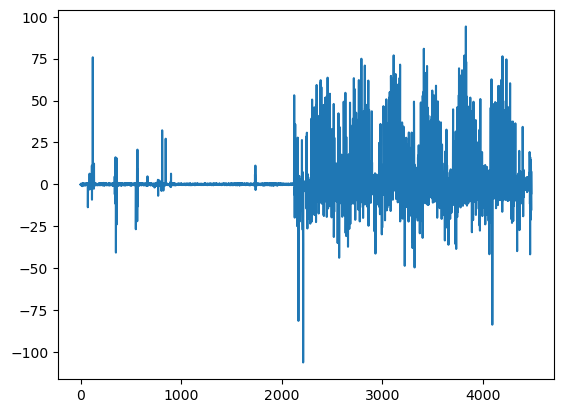

In [24]:
plt.plot(sim['z_kz'][3,:])